# CNN for counting 
This fil is for CNN applicationThis notebook presents a CNN-based approach developed for COBALT to automate sperm cell counting in microscopic images. The goal is to build a reliable model that can accurately detect and count cells, streamlining the fertility analysis process.

We’ll cover data preparation, model design, and evaluation to achieve an efficient and accurate cell-counting solution.

---

# Importing necessary libraries for the project

In [2]:
# Standard libraries
import sys
import os

# Adding a custom toolkit repository to the system path
# This allows for easy importing of custom tools from 'tool_kit' located in a parent directory
path_to_tool_kit = os.path.abspath('/homes/i23damma/Bureau/Cobalt/cobalt')
#path_to_tool_kit = os.path.abspath('..')
if path_to_tool_kit not in sys.path:
    sys.path.append(path_to_tool_kit)

# Import custom toolkit functions (e.g., utility functions or model-related functions)
import tool_kit as tk
sys.path.append('/homes/i23damma/Bureau/Cobalt/cobalt/CNN')
# Data manipulation and numerical operations
import numpy as np  # To install: `pip install numpy`
import pandas as pd  # To install: `pip install pandas`

# PyTorch library for image transformations
import torchvision.transforms as transforms  # To install: `pip install torchvision`

# Library for data visualization
import matplotlib.pyplot as plt  # To install: `pip install matplotlib`

# Importing PyTorch summary for model inspection
#from torchsummary import summary  # To install: `pip install torchsummary`

# Core PyTorch libraries for deep learning
import torch  # To install: `pip install torch`
import torch.nn as nn
import torch.nn.functional as F

# Additional utility functions and tools
from torch.utils.data.sampler import SubsetRandomSampler
from costumize_data import CustomDataset  # Custom dataset handler



# Loading and Displaying Dataset Information

In [4]:
# Setting the path to the dataset using a function from the custom toolkit
# This allows the toolkit to locate and access the dataset files.
tk.set_path_to_dataset('/homes/i23damma/Bureau/Cobalt/cobalt/')
#tk.set_path_to_dataset('..')

# Loading the images and mask data using functions from the toolkit
images = tk.load_data_image()
mask = tk.load_data_mask()
# Displaying the first few entries of each DataFrame to understand the data structure
print(' images =\n', images.head())
print(' mask =\n', mask.head())
# 'mask' DataFrame:# - Type: pandas DataFrame# - Contains: Each entry has the image ID and the count of cells present in the image.
# 'images' DataFrame:# - Type: pandas DataFrame # - Contains: Each entry has the image ID, cell count, mask availability (boolean), and blur status.


 images =
                             image_id  nb_cells mask  blur
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1  yes     1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1  yes     1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1  yes     1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1  yes     1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1  yes     1
 mask =
                             image_id  nb_cells
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1


Select the data frame that you want to use # Selecting DataFrame Based on User Choice: Mask or Image

In [5]:
mask_or_image = 'mask'  # Variable to determine which dataset to use

if mask_or_image == 'mask':
    df = mask  # If 'mask' is selected, assign the mask DataFrame to df
    # Filter the rows in the DataFrame where 'image_id' contains 'w1' (case insensitive)
    #df = df[df['image_id'].str.contains("w1", case=False, na=False)]
else:
    df = images.copy()  # If 'image' is selected, create a copy of the images DataFrame
    # Remove the 'blur' and 'mask' columns from the DataFrame
    #df.drop(columns=['blur', 'mask'], inplace=True) 
    # Uncomment the following line to filter images by 'w1' if needed
    # df = df[df['image_id'].str.contains("w1", case=False, na=False)]



#df=df[df['nb_cells'] > 50]
df  # Display the resulting DataFrame


,image_id,nb_cells
0,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1
1,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1
2,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1
3,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1
4,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1
...,...,...
1195,SIMCEPImages_A24_C100_F1_s23_w2.TIF,100
1196,SIMCEPImages_A24_C100_F1_s24_w1.TIF,100
1197,SIMCEPImages_A24_C100_F1_s24_w2.TIF,100
1198,SIMCEPImages_A24_C100_F1_s25_w1.TIF,100


## Separation test set et train set# Splitting the Dataset into Training and Testing Sets

In [6]:
mean_label= df['nb_cells'].mean()
std_label = df['nb_cells'].std()
# Centralisation et normalisation de la colonne 'label'
df['nb_cells'] = (df['nb_cells'] - df['nb_cells'].mean()) / df['nb_cells'].std()

In [7]:
# Set the fraction of data to be used for testing
frac = 0.15  # 20% of the data will be used for the test set
# Sample a subset of the DataFrame for testing without replacement
df_test = df.sample(frac=frac, replace=False, random_state=42)
# Create the training set by dropping the test set entries from the original DataFrame. Then shuffle the remaining data to create the training set
df_train = df.drop(df_test.index).sample(frac=1, random_state=42)

print('len(df) =', len(df))  # Total number of samples in the original DataFrame
print('len(df_train) =', len(df_train))  # Number of samples in the training set
print('len(df_test) =', len(df_test))  # Number of samples in the test set

print('df_train =\n', df_train.head())  # Show the first few rows of the training DataFrame
print('df_test =\n', df_test.head())  # Show the first few rows of the testing DataFrame


len(df) = 1200
len(df_train) = 1020
len(df_test) = 180
df_train =
                                image_id  nb_cells
627  SIMCEPImages_A13_C53_F1_s14_w2.TIF  0.083934
716  SIMCEPImages_A15_C61_F1_s09_w1.TIF  0.352525
631  SIMCEPImages_A13_C53_F1_s16_w2.TIF  0.083934
33    SIMCEPImages_A01_C1_F1_s17_w2.TIF -1.661901
733  SIMCEPImages_A15_C61_F1_s17_w2.TIF  0.352525
df_test =
                                  image_id  nb_cells
1178  SIMCEPImages_A24_C100_F1_s15_w1.TIF  1.661901
865    SIMCEPImages_A18_C74_F1_s08_w2.TIF  0.788983
101    SIMCEPImages_A03_C10_F1_s01_w2.TIF -1.359737
439    SIMCEPImages_A09_C35_F1_s20_w2.TIF -0.520393
58      SIMCEPImages_A02_C5_F1_s05_w1.TIF -1.527606


## Sample Images from the Dataset 


In [8]:
# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")
# Print the length of the training DataFrame
print(f"Number of training samples: {len(df_train)}")

DataFrame shape: (1200, 2)
Number of training samples: 1020


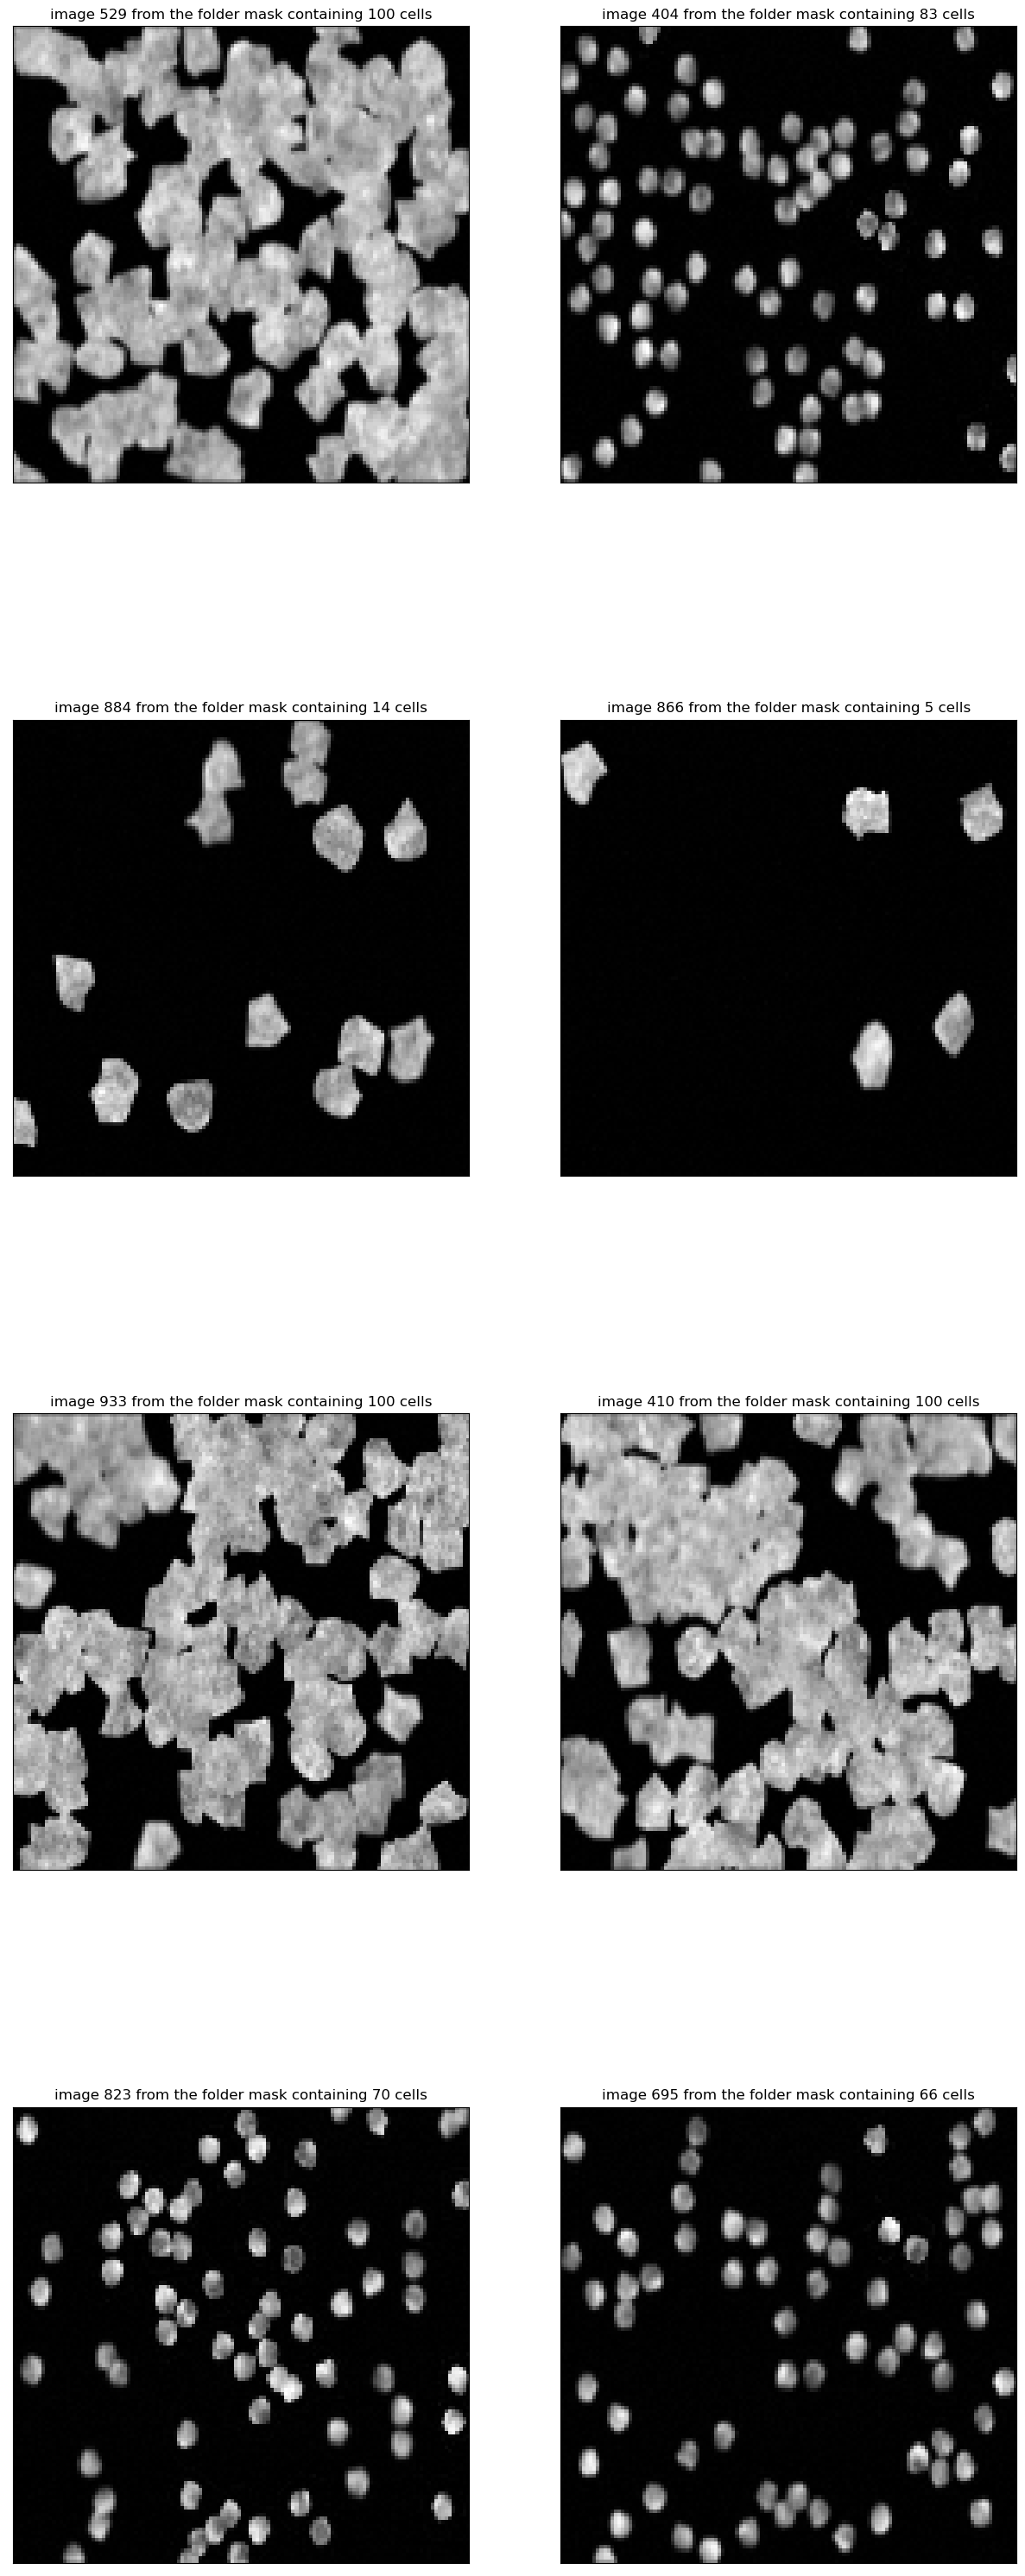

In [9]:
# Set the image height and width
IMG_HEIGHT = 128
IMG_WIDTH = 128
# Assign the training DataFrame to Matrix
Matrix = df_train
# Number of images to show
n_img_to_show = 8
# Create a figure with a specified size
fig = plt.figure(figsize=(15, 5*n_img_to_show ))
# Create a list of indices based on the length of the Matrix
indices = list(range(len(Matrix)))
# Shuffle the indices randomly
np.random.shuffle(indices)
# Loop through the number of images to show
for i in range(n_img_to_show):
    # Add a subplot to the figure
    ax = fig.add_subplot( n_img_to_show // 2,2, i + 1, xticks=[], yticks=[])
    # Get the image using the tk.get_image function and display it
    ax.imshow(np.squeeze(tk.get_image(
        img_id=Matrix['image_id'].iloc[indices[i]],
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        mask_or_image=mask_or_image
    )), cmap='gray')
    # Set the title of the subplot
    ax.set_title(f'image {indices[i]} from the folder {mask_or_image} containing {int((Matrix["nb_cells"].iloc[indices[i]])*std_label+mean_label)} cells')
# Show the figure
plt.show()

# Convertit les données pour pytorch

# Creating Data Loaders for Training, Validation, and Testing

In [10]:
# Define batch size and validation size
batch_size = 20  # Number of samples per batch to load  # mettre en puissance de 2 #plus batch size est grand plus learn rate est peut etre elevée 
valid_size = 0.1  # Percentage of training set to use as validation

# Function to create data loaders for training, validation, and testing
def create_data_loaders(batch_size, valid_size, train_data, test_data):
  # Create a data loader for the test dataset
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  # Generate a list of indices for the training data and shuffle them
  indices = list(range(len(train_data)))
  np.random.shuffle(indices)
  # Calculate the split index for validation data
  split = int(np.floor(valid_size * len(train_data)))
  # Split the indices into training and validation indices
  train_indexes, valid_indexes = indices[split:], indices[:split]
  # Create samplers for validation and training data
  valid_samplers = SubsetRandomSampler(valid_indexes)
  train_samplers = SubsetRandomSampler(train_indexes)
  # Create data loaders for validation and training data using the samplers
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_samplers)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_samplers)
  # Return the data loaders
  return train_loader, valid_loader, test_loader




In [9]:
type(df_train)

pandas.core.frame.DataFrame

In [10]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH))  # Resize the image to the desired dimensions
])
# Create the training dataset using the custom dataset class and the defined transformation
train_data = CustomDataset(df_train, transform=transform)
train_data.set_path_to_dataset('..')  # Set the path to the dataset for the training data
# Create the testing dataset using the custom dataset class and the defined transformation
test_data = CustomDataset(df_test, transform=transform)
test_data.set_path_to_dataset('..')  # Set the path to the dataset for the testing data
# Create data loaders for training, validation, and testing datasets
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

In [11]:
print(train_data.__getitem__(100)[0])
torch.max(train_data.__getitem__(100)[0])

tensor([[[0.0044, 0.0054, 0.0022,  ..., 0.0021, 0.0026, 0.0035],
         [0.0032, 0.0020, 0.0033,  ..., 0.0034, 0.0027, 0.0031],
         [0.0049, 0.0024, 0.0020,  ..., 0.0042, 0.0034, 0.0034],
         ...,
         [0.0031, 0.0041, 0.0043,  ..., 0.3852, 0.0598, 0.0047],
         [0.0029, 0.0017, 0.0028,  ..., 0.5748, 0.1289, 0.0084],
         [0.0021, 0.0038, 0.0030,  ..., 0.5612, 0.1431, 0.0086]]])


tensor(0.8969)

In [12]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cpu


# Training method

In [13]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, name):
  """
    Train and validate the model.

    Parameters:
    n_epochs (int): Number of epochs to train the model.
    train_loader (DataLoader): DataLoader for the training data.
    valid_loader (DataLoader): DataLoader for the validation data.
    model (nn.Module): The neural network model to train.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.

    Returns:
    train_losses (list): List of training losses for each epoch.
    valid_losses (list): List of validation losses for each epoch.
    """
  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          
          optimizer.zero_grad()
          output=model(data)
          #print('label=',label,'\n','output=',output)
          output= output.view(-1)
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.float32)

        with torch.no_grad():
          output=model( data)
          
        output= output.view(-1)
        loss=criterion(label,output)
        valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
      
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), name)
          valid_loss_min = valid_loss

  return train_losses, valid_losses

# Train 

# Evaluation method 

In [14]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(101))
  class_total = list(0. for i in range(101))
  #creat a empty dict of 101 elements
  dict={}
  for i in range(1,101):
      dict[i]=[]
  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.float32)
      
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      
      loss = criterion(output, label)

      test_loss += loss.item()*data.size(0)
      
      pred = (output*std_label+mean_label) # convert output probabilities to predicted class
      
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          number_expected = int(label.data[i]*std_label+mean_label)
          
          class_correct[number_expected] += correct[i].item()
          class_total[number_expected] += 1
          
          
          
          dict[number_expected].append(int(pred[i]))
      
  
  #print and return the results
  for i in range(100):
     if class_total[i] > 0 : 
        print( 'For the true value ', i, 'the predicted values are ', dict[i])
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(100):
      if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test accuracy of %1s: %2.2f%% (%2d/%2d)' % (str(i), accuracy, np.sum(class_correct[i]), np.sum(class_total[i])))
      #else: 
        #print('Test accuracy of %1s: N/A (0/0)' % str(i))

  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

# Evaluate

# KAGGLE CNN Model Definition

# class definition

In [15]:


class KAGGLE_CNN(nn.Module):
    def __init__(self, img_height, img_width, img_channels=1, padding=1, kernel_size=3, pool_size=2,
                 first_filters=32, second_filters=64, third_filters=128, 
                 dropout_conv=0.0, dropout_dense=0.0):
        super(KAGGLE_CNN, self).__init__()

        # Layer 1: Initial Conv layer with padding
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=first_filters, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv3 = nn.Conv2d(in_channels=first_filters, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout1 = nn.Dropout(dropout_conv)

        # Layer 2: Second convolutional block
        self.conv4 = nn.Conv2d(in_channels=first_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv5 = nn.Conv2d(in_channels=second_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv6 = nn.Conv2d(in_channels=second_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout2 = nn.Dropout(dropout_conv)

        # Layer 3: Third convolutional block
        self.conv7 = nn.Conv2d(in_channels=second_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv8 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv9 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout3 = nn.Dropout(dropout_conv)

        # Layer 4: Fourth convolutional block
        self.conv10 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.conv11 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.conv12 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.pool4 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout4 = nn.Dropout(dropout_conv)

        # Calculate flattened size for fully connected layers
        self.flattened_size = self._calculate_flattened_size(img_height, img_width, pool_size)

        # Dense layers
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.leaky_relu1 = nn.LeakyReLU()
        self.batch_norm1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.leaky_relu2 = nn.LeakyReLU()
        self.batch_norm2 = nn.BatchNorm1d(512)

        # Output layer
        self.output = nn.Linear(512, 1)

    def _calculate_flattened_size(self, height, width, pool_size):
        # Apply pool size four times based on the four pooling layers in the model
        for _ in range(4):
            height //= pool_size
            width //= pool_size
        return height * width * 128  # `128` is `third_filters`, which is the final filter count

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool4(x)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.leaky_relu1(self.fc1(x))
        x = self.batch_norm1(x)

        x = self.leaky_relu2(self.fc2(x))
        x = self.batch_norm2(x)

        x = self.output(x)
        x=F.relu(x)
        return x


# CHOSE THE DEVICE

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


# CREATE the model 

In [17]:
CNN_2 = KAGGLE_CNN( img_height=IMG_HEIGHT, img_width=IMG_WIDTH )
CNN_2.to(device=device)  

KAGGLE_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.0, inplace=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.0, inplace=False)
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_siz

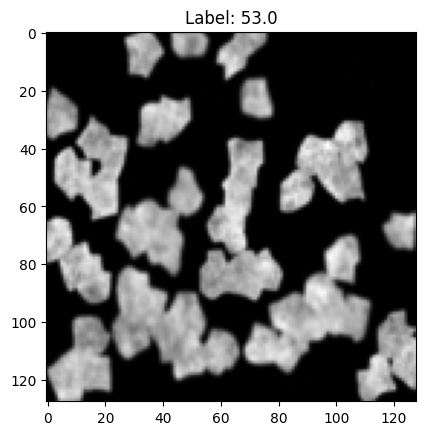

In [18]:
# Visualize the item
image, label = train_data.__getitem__(0)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.title(f'Label: {label*std_label+mean_label}')
plt.show()

In [19]:
#get the sumamry 
summary(CNN_2, input_size=(1, IMG_HEIGHT, IMG_WIDTH))  # Explicitly set batch_size=1 # channels, height, width )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
            Conv2d-2         [-1, 32, 128, 128]           9,248
            Conv2d-3         [-1, 32, 128, 128]           9,248
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
            Conv2d-7           [-1, 64, 64, 64]          36,928
            Conv2d-8           [-1, 64, 64, 64]          36,928
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
           Conv2d-12          [-1, 128, 32, 32]         147,584
           Conv2d-13          [-1, 128, 32, 32]         147,584
        MaxPool2d-14          [-1, 128,

# Define the criterion and the loss

In [20]:
# Define the loss function as Mean Squared Error Loss
criterion = nn.MSELoss()

# Alternatively, you can use Smooth L1 Loss by uncommenting the following line
# criterion = nn.SmoothL1Loss()

# Define the optimizer as Adam with a learning rate of 0.001
optimizer = torch.optim.Adam(CNN_2.parameters(), lr=0.001)

In [21]:
n_epochs = 2 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, name):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          optimizer.zero_grad()
          output=model(data)
          output= output.view(-1)
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          with torch.no_grad():
              output=model( data)
              output= output.view(-1)
          loss=criterion(output,label)
          valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), name)
          valid_loss_min = valid_loss

  return train_losses, valid_losses

# Train 

In [22]:
name= 'kagglemodel_1.pt'
train_losses_k, valid_losses_k=training(n_epochs, train_loader, valid_loader, CNN_2, criterion, optimizer, name )

epoch: 1 	training Loss: 1.564555 	validation Loss: 1.287917
validation loss decreased (inf --> 1.287917).  Saving model ...
epoch: 2 	training Loss: 0.790261 	validation Loss: 1.287917


# Plotting Training and Validation Losses for KAGGLE CNN

Text(0, 0.5, 'loss value')

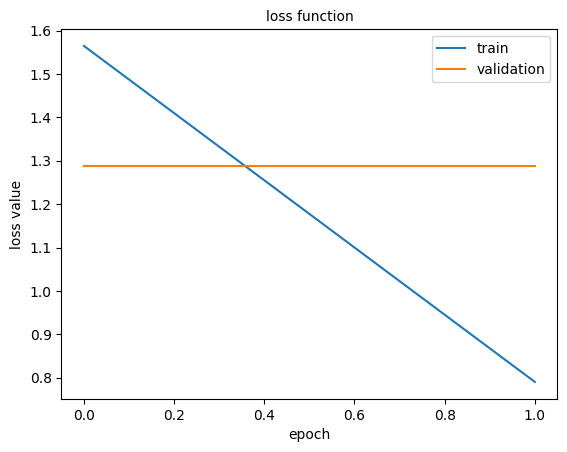

In [23]:
plt.plot(range(n_epochs), train_losses_k)
plt.plot(range(n_epochs), valid_losses_k)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

# Evaluate

In [24]:
evaluation( CNN_2, test_loader, criterion)

c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


For the true value  1 the predicted values are  [50, 50, 50, 50, 50]
For the true value  5 the predicted values are  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
For the true value  10 the predicted values are  [50, 50, 50, 50, 50, 50, 50, 50]
For the true value  14 the predicted values are  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
For the true value  18 the predicted values are  [50, 50, 50, 50, 50, 50, 50]
For the true value  23 the predicted values are  [50, 50, 50, 50, 50, 50, 50, 50]
For the true value  27 the predicted values are  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
For the true value  31 the predicted values are  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
For the true value  35 the predicted values are  [50, 50, 50, 50, 50, 50, 50, 50, 50]
For the true value  40 the predicted values are  [50, 50, 50, 50, 50]
For the true value  44 the predicted values are  [50, 50, 50, 50, 50, 50, 50]
For the true value  48 the predicted values are  [50, 50, 50, 50, 50, 50]
For th

## boucles d'entrainement 

In [ ]:
n_epochs = 20 # number of epochs to train the model
lr_values=[0.0001]
dropout_conv=[0.0, 0.3]
results={}
for dc in dropout_conv:
    for lr in lr_values:
        train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) 
        print(f'For the dataset {mask_or_image}, start the experience for the learning rate {lr}, for the dropout_conv {dc}   :')
        name= f'kagglemodel_lr_{lr}_dc_{dc}.pt'
        CNN_2 = KAGGLE_CNN( img_height=IMG_HEIGHT, img_width=IMG_WIDTH, dropout_conv=dc )
        CNN_2.to(device=device) 
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(CNN_2.parameters(), lr=lr)
        train_losses_k, valid_losses_k=training(n_epochs, train_loader, valid_loader, CNN_2, criterion, optimizer, name )
        evaluation( CNN_2, test_loader, criterion)
        results[(lr, dc, mask_or_image)]= train_losses_k , valid_losses_k
        


For the dataset mask, start the experience for the learning rate 0.001, for the dropout_conv 0.0   :
epoch: 1 	training Loss: 1.192116 	validation Loss: 0.929424
validation loss decreased (inf --> 0.929424).  Saving model ...
epoch: 2 	training Loss: 0.797401 	validation Loss: 0.858392
validation loss decreased (0.929424 --> 0.858392).  Saving model ...
epoch: 3 	training Loss: 0.786269 	validation Loss: 0.712718
validation loss decreased (0.858392 --> 0.712718).  Saving model ...
epoch: 4 	training Loss: 0.792440 	validation Loss: 177.368723
epoch: 5 	training Loss: 0.841784 	validation Loss: 41.843531
epoch: 6 	training Loss: 0.798690 	validation Loss: 0.760939
epoch: 7 	training Loss: 0.798283 	validation Loss: 0.733235
epoch: 8 	training Loss: 0.801294 	validation Loss: 0.787216
epoch: 9 	training Loss: 0.760614 	validation Loss: 14.631196
epoch: 10 	training Loss: 0.722861 	validation Loss: 0.581126
validation loss decreased (0.712718 --> 0.581126).  Saving model ...
epoch: 11 	tr